In [1]:

import numpy as np
from typing import Tuple, List
import networkx as nx

from auto_robot_design.description.kinematics import JointPoint
from auto_robot_design.description.builder import add_branch
from auto_robot_design.description.utils import draw_joint_point

In [2]:
np.array([1,2,3])

array([1, 2, 3])

In [3]:
def build_standard_two_linker(variant:int = 2,nominal_length = 1, right_shift = np.tan(np.pi/6)/2):
    ground_joint = JointPoint(
        r=np.zeros(3),
        w=np.array([0, 1, 0]),
        attach_ground=True,
        active=True,
        name="TL_ground"
    )
    graph_dict = {"TL_ground":ground_joint}
    branch = [ground_joint]
    if variant not in (1,2,3): raise Exception("wrong variant!")
    knee_joint_pos = np.array([right_shift, 0, -variant * 0.25])
    knee_joint = JointPoint(r=knee_joint_pos, w=np.array([0, 1, 0]), name=f"TL_knee")
    branch.append(knee_joint)
    graph_dict["TL_knee"] = knee_joint
    ee = JointPoint(
        r=np.array([0,0,-1]),
        w=np.array([0, 1, 0]),
        attach_endeffector=True,
        name="TL_ee"
    )
    graph_dict["TL_ee"] = ee
    branch.append(ee)
    graph = nx.Graph()
    add_branch(graph, branch)
    return graph, graph_dict




In [4]:
False * 5.0


0.0

In [5]:
def add_tl_branch(graph, graph_dict, inner:bool = True, shift = 0.25, ground:bool = True):
    knee_joint:JointPoint = graph_dict["TL_knee"]
    knee_pos = knee_joint.r
    ee:JointPoint = graph_dict["TL_ee"]
    ee_pos = ee.r
    connection_point = (ee_pos + knee_pos)/2
    if inner:
        branch_knee_pos = knee_pos + np.array([-knee_pos[0]-shift,0,0])
    else:
        branch_knee_pos = knee_pos + np.array([shift,0,0])

    branch_knee_joint = JointPoint(r=branch_knee_pos,
        w=np.array([0, 1, 0]),
        name="TL_branch_knee")
    branch_connection = JointPoint(r=connection_point,
        w=np.array([0, 1, 0]),
        name="TL_branch_connection")
    
    if ground:
        ground_connection = np.array([branch_knee_pos[0],0,0])
        branch_ground_joint = JointPoint(r=ground_connection,
            w=np.array([0, 1, 0]),
            attach_ground=True,
            active=True,
            name="TL_branch_ground")
        add_branch(graph, [branch_ground_joint, branch_knee_joint, branch_connection,[knee_joint, ee]])
        return graph
    else:
        ground_joint:JointPoint = graph_dict["TL_ground"]
        ground_connection = (ground_joint.r+knee_pos)/2
        branch_ground_joint = JointPoint(r=ground_connection,
            w=np.array([0, 1, 0]),
            active=True,
            name="TL_branch_ground")
        add_branch( graph, [[ground_joint, knee_joint],branch_ground_joint, branch_knee_joint, branch_connection,[knee_joint, ee]])
        return graph



In [6]:
# def add_fl_branch(graph, graph_dict, inner:bool = True, shift = 0.25, ground:bool = True, variant = 2):
#     knee_joint:JointPoint = graph_dict["TL_knee"]
#     knee_pos = knee_joint.r
#     ee:JointPoint = graph_dict["TL_ee"]
#     ee_pos = ee.r
#     ground_joint:JointPoint = graph_dict["TL_ground"]
#     ground_pos = ground_joint.r

#     connection_point = (ee_pos + knee_pos)/2
#     if inner:
#         branch_knee_pos = connection_point+ np.array([-connection_point[0]-shift,0,0])
#     else:
#         branch_knee_pos = connection_point+ np.array([-connection_point[0] + knee_pos[0]+shift,0,0])
    
#     upper_connection_point = (ground_pos + knee_pos)/2
#     if inner:
#         branch_hip_pos = upper_connection_point + np.array([-upper_connection_point[0]-shift,0,0])
#     else:
#         branch_hip_pos = upper_connection_point+ np.array([-upper_connection_point[0] + knee_pos[0]+shift,0,0])
    
#     branch_hip_joint = JointPoint(r=branch_hip_pos,
#         w=np.array([0, 1, 0]),
#         name="FL_branch_hip")
#     branch_knee_joint = JointPoint(r=branch_knee_pos,
#         w=np.array([0, 1, 0]),
#         name="FL_branch_knee")
#     branch_connection = JointPoint(r=connection_point,
#         w=np.array([0, 1, 0]),
#         name="FL_branch_connection")
    
#     if ground:
#         branch_ground_connection = np.array([branch_hip_pos[0], 0, 0])
#         branch_ground_joint = JointPoint(r=branch_ground_connection,
#         w=np.array([0, 1, 0]),
#         active=True,
#         attach_ground=True)
#         branch =[branch_ground_joint, branch_hip_joint, branch_knee_joint, branch_connection]
#         add_branch(graph,[branch_ground_joint, branch_hip_joint, branch_knee_joint, branch_connection,[knee_joint, ee]])

#         upper_connection_joint = JointPoint(r=upper_connection_point,
#         w=np.array([0, 1, 0]),
#         name="FL_branch_addition_connection")

#         addition_initial_pos = (branch[variant].r+branch[variant-1].r)/2
#         addition_initial_joint = JointPoint(r=addition_initial_pos,
#         w=np.array([0, 1, 0]),
#         name="FL_branch_addition_initial")
#         add_branch(graph,[[branch[variant],branch[variant-1]], addition_initial_joint, upper_connection_joint, [ground_joint, knee_joint]])
#         return graph
#     else:
        

        

In [7]:
import itertools
list(itertools.permutations([1, 2, 3]))

[(1, 2, 3), (1, 3, 2), (2, 1, 3), (2, 3, 1), (3, 1, 2), (3, 2, 1)]

In [8]:
def set_circle_points(pos_1, pos_2, add_pos,n):
    center = (pos_1+pos_2)/2
    vec = pos_1-center
    if np.linalg.norm(add_pos-center)>np.linalg.norm(pos_1-center):
        pos_turn = center + np.array([vec[0]*np.cos(np.pi/n)-vec[2]*np.sin(np.pi/n), 0, vec[2]*np.cos(np.pi/n)+vec[0]*np.sin(np.pi/n)])
        neg_turn = center + np.array([vec[0]*np.cos(-np.pi/n)-vec[2]*np.sin(-np.pi/n),0, vec[2]*np.cos(-np.pi/n)+vec[0]*np.sin(-np.pi/n)])
        new_pos_list = []
        crit = int((-0.5+int(np.linalg.norm(pos_turn-add_pos)<np.linalg.norm(neg_turn-add_pos)))*2)
        for i in range(crit*1,crit * n,crit):
            angle = i*np.pi/n
            new_pos_list.append(center + np.array([vec[0]*np.cos(angle)-vec[2]*np.sin(angle),0, vec[2]*np.cos(angle)+vec[0]*np.sin(angle)]))
    else:
        new_pos_list = []
        for i in range(1, n):
            new_pos_list.append(pos_1 + (pos_2-pos_1)/n*i)
    return new_pos_list

In [9]:

def add_fl_branch(graph, graph_dict, inner:bool = True, shift = 0.5, ground:bool = True, variant = 0):
    knee_joint:JointPoint = graph_dict["TL_knee"]
    knee_pos = knee_joint.r
    ee:JointPoint = graph_dict["TL_ee"]
    ee_pos = ee.r
    ground_joint:JointPoint = graph_dict["TL_ground"]
    ground_pos = ground_joint.r


    if inner:
        branch_ground_pos = np.array([-shift,0,0])
    else:
        branch_ground_pos = np.array([shift,0,0])

    connection_top =  (ground_pos + knee_pos)/2
    connection_bot = (ee_pos + knee_pos)/2

    branch_ground_joint = JointPoint(r=branch_ground_pos,
        w=np.array([0, 1, 0]),
        active=True,
        attach_ground=True,name="FL_branch_ground")
    top_joint = JointPoint(r=connection_top,
        w=np.array([0, 1, 0]),
        name="FL_branch_top")
    bot_joint = JointPoint(r=connection_bot,
        w=np.array([0, 1, 0]),
        name="FL_branch_bot")
    new_joint_dict = {branch_ground_joint:[], top_joint:[[ground_joint, knee_joint]],bot_joint:[[ee, knee_joint]]}
    # triangle with 3 connections
    if variant == 0:
        pos_1 = np.array([branch_ground_joint.r[0], 0, bot_joint.r[2]])
        pos_2 = np.array([branch_ground_joint.r[0], 0, bot_joint.r[2]/2])
        j1 = JointPoint(r=pos_1,
        w=np.array([0, 1, 0]),
        name="FL_branch_knee")
        j2 = JointPoint(r=pos_2,
        w=np.array([0, 1, 0]),
        name="FL_branch_hip")
        add_branch(graph,[[ee,knee_joint], bot_joint, j1, j2, branch_ground_joint])
        j3 = JointPoint(r=(pos_1+pos_2)/2,
        w=np.array([0, 1, 0]),
        name="FL_branch_additional")
        add_branch(graph,[[ground_joint, knee_joint], top_joint, j3, [j1,j2]])
        return graph

    else:
        new_joints = [branch_ground_joint, top_joint,bot_joint]
        permutation = list(itertools.permutations(new_joints))[variant-1]

        new_joint_pos = set_circle_points(permutation[0].r,permutation[2].r,permutation[1].r, 4)
        branch = new_joint_dict[permutation[0]]
        branch.append(permutation[0])
        for i, pos in enumerate(new_joint_pos):
            joint = JointPoint(r=pos, w=np.array([0, 1, 0]), name=f"FL_branch_j{i}")
            branch.append(joint)

        branch.append(permutation[2])
        branch += new_joint_dict[permutation[2]]
        add_branch(graph, branch)
        if permutation[0].attach_ground:
            branch_2 = [[branch[1],branch[2]], permutation[1]]+new_joint_dict[permutation[1]]
        else:
            branch_2 = [[branch[2],branch[3]], permutation[1]]+new_joint_dict[permutation[1]]
        add_branch(graph,branch_2)
        return graph

        

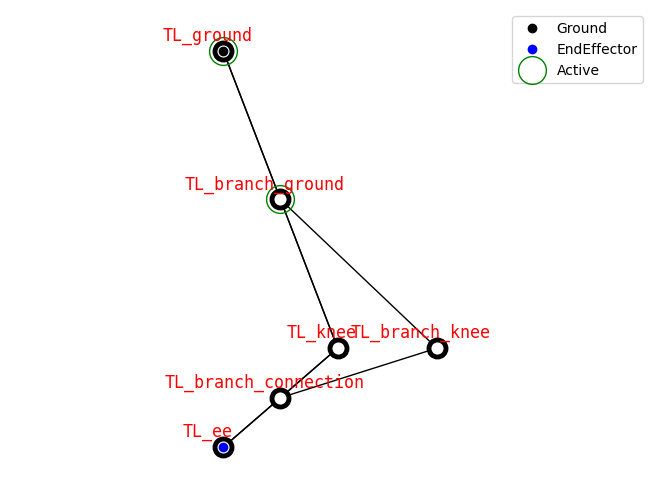

In [10]:
graph, graph_dict = build_standard_two_linker(variant=3)
add_tl_branch(graph, graph_dict,ground=False, inner=False)
#add_fl_branch (graph, graph_dict,ground=True, inner=False, variant = 6
#               , shift = 0.5)
draw_joint_point(graph)

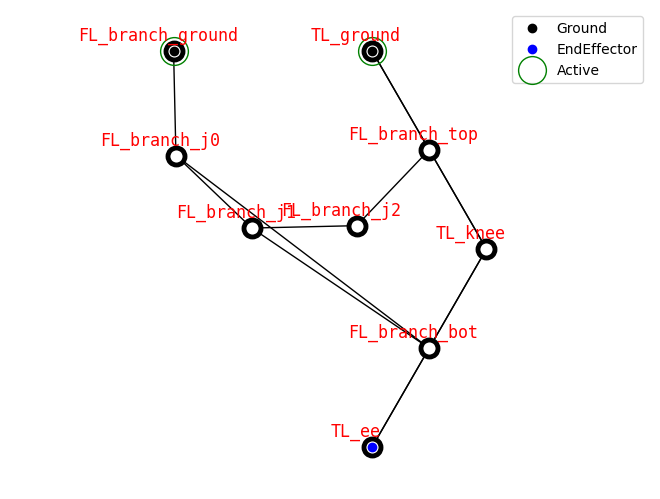

In [14]:
from two_link_generator import TwoLinkGenerator

gen = TwoLinkGenerator()


draw_joint_point(gen.get_standard_set()[4])